# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2023-2024 exercise 2

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 28.4.2024

## Initialisation

In [1]:
%matplotlib inline 

In [2]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner

from pytransit import TransitLPF

seterr('ignore')
seed(0)

### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [3]:
tb = Table.read('data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

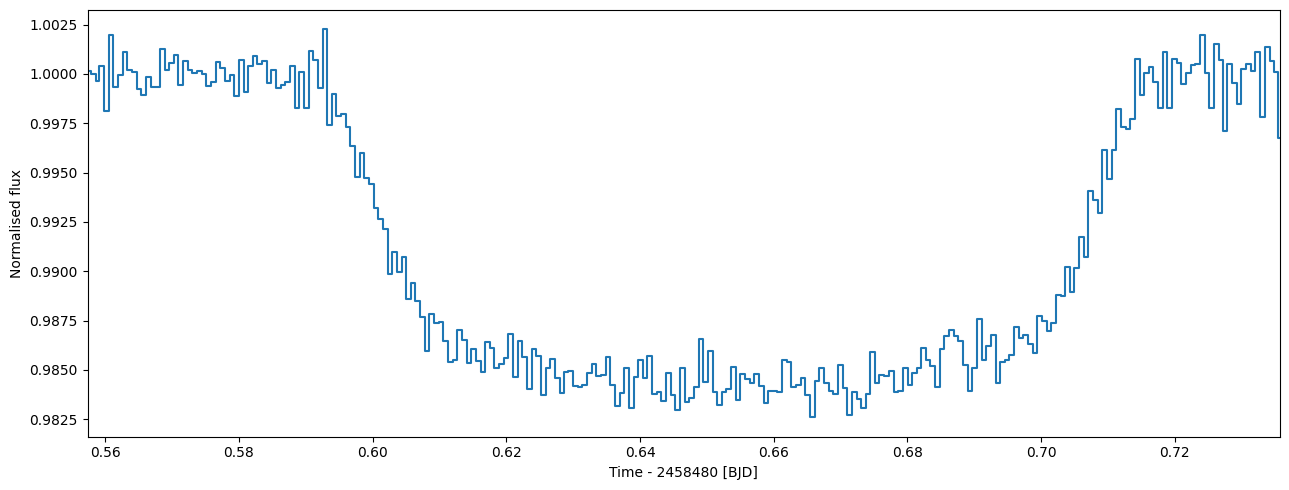

In [4]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [5]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [6]:
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [7]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

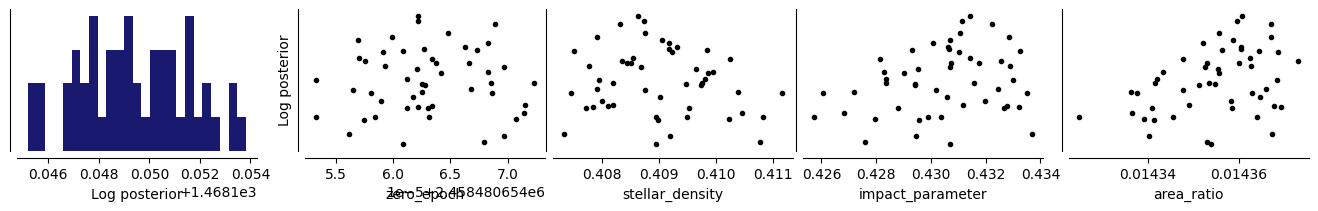

In [8]:
lpf.optimize_global(niter=500, npop=50)

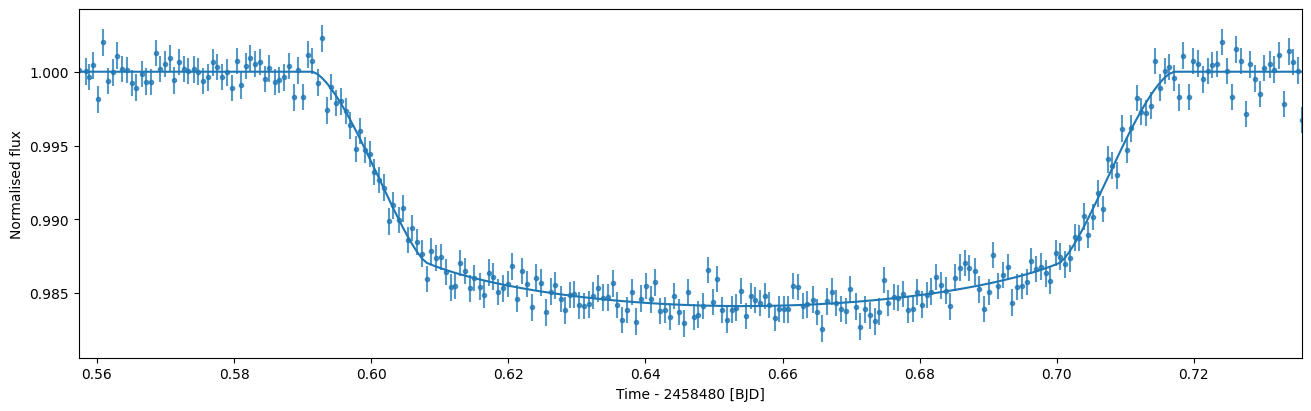

In [9]:
lpf.plot_light_curve();

In [10]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

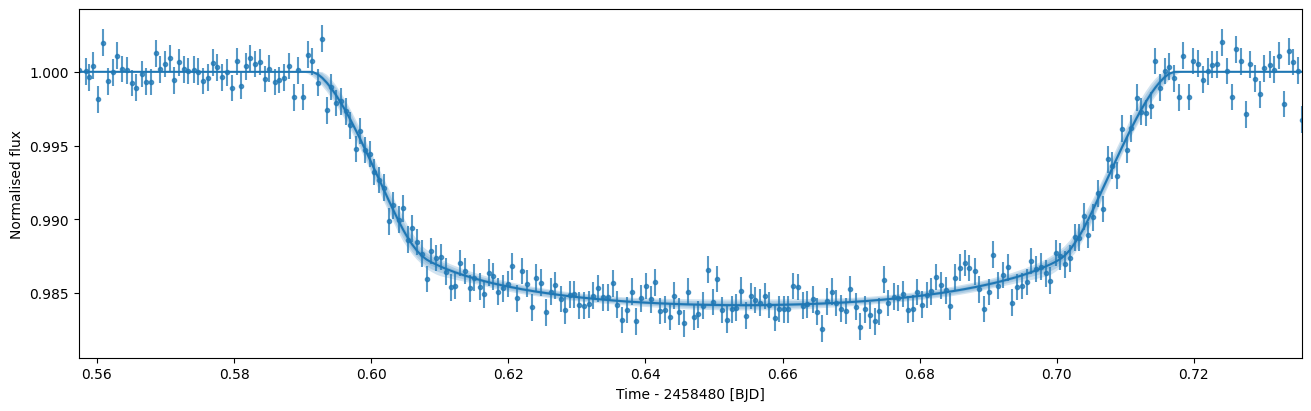

In [11]:
lpf.plot_light_curve('mc');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

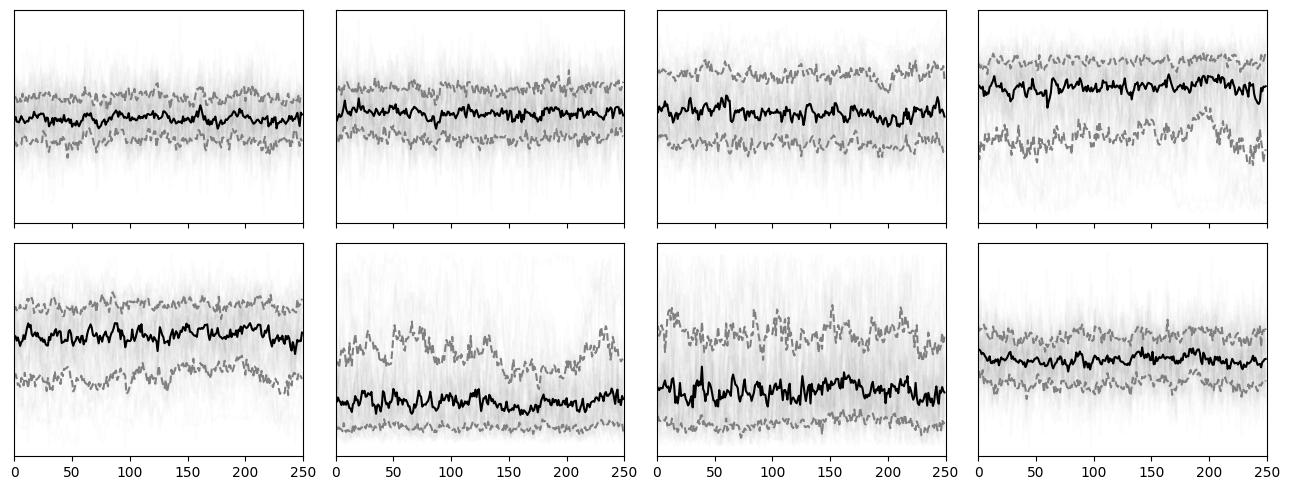

In [12]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [13]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [14]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

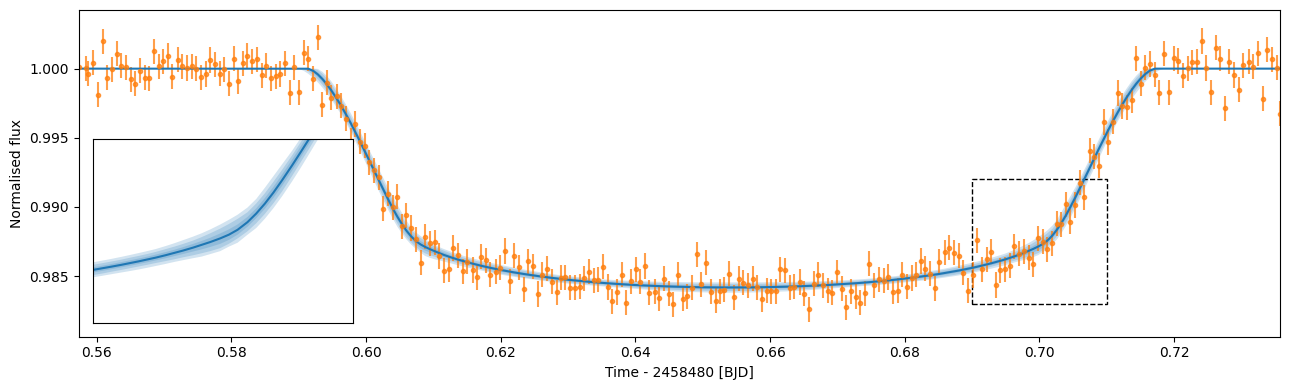

In [15]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()

az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0');

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [16]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4341,3.4082e-01,0.0140,0.3131,0.3404,-3.0417,0.1182,3.0102,1.4562,0.1258,0.0945
std,1.6024e-04,1.0852e-09,0.0359,1.1591e-01,0.0004,0.1961,0.2313,0.0196,0.0019,0.0831,0.0412,0.0010,0.0025
min,2.4585e+06,1.0914e+00,0.3228,4.4660e-05,0.0126,0.0439,0.0001,-3.1107,0.1124,2.7293,1.3616,0.1227,0.0867
25%,2.4585e+06,1.0914e+00,0.4070,2.7669e-01,0.0137,0.1645,0.1579,-3.0554,0.1169,2.9485,1.4254,0.1251,0.0926
50%,2.4585e+06,1.0914e+00,0.4317,3.7042e-01,0.0140,0.2618,0.2885,-3.0417,0.1184,3.0068,1.4473,0.1257,0.0943
75%,2.4585e+06,1.0914e+00,0.4615,4.2769e-01,0.0143,0.4047,0.4820,-3.0286,0.1196,3.0746,1.4807,0.1264,0.0964
max,2.4585e+06,1.0914e+00,0.5321,5.6682e-01,0.0151,0.9983,0.9998,-2.9570,0.1227,3.2239,1.5708,0.1295,0.1017


<Axes: >

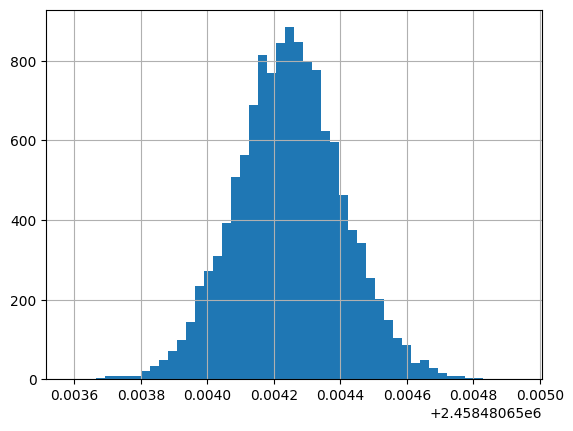

In [17]:
df.tc.hist(bins=50)

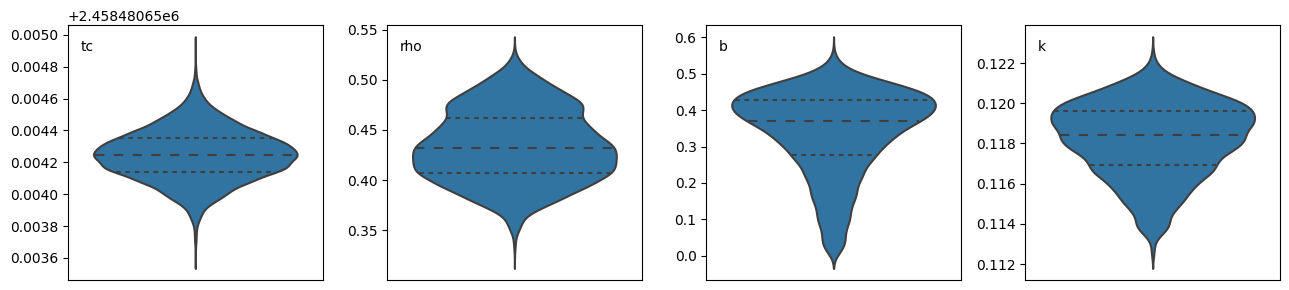

In [18]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

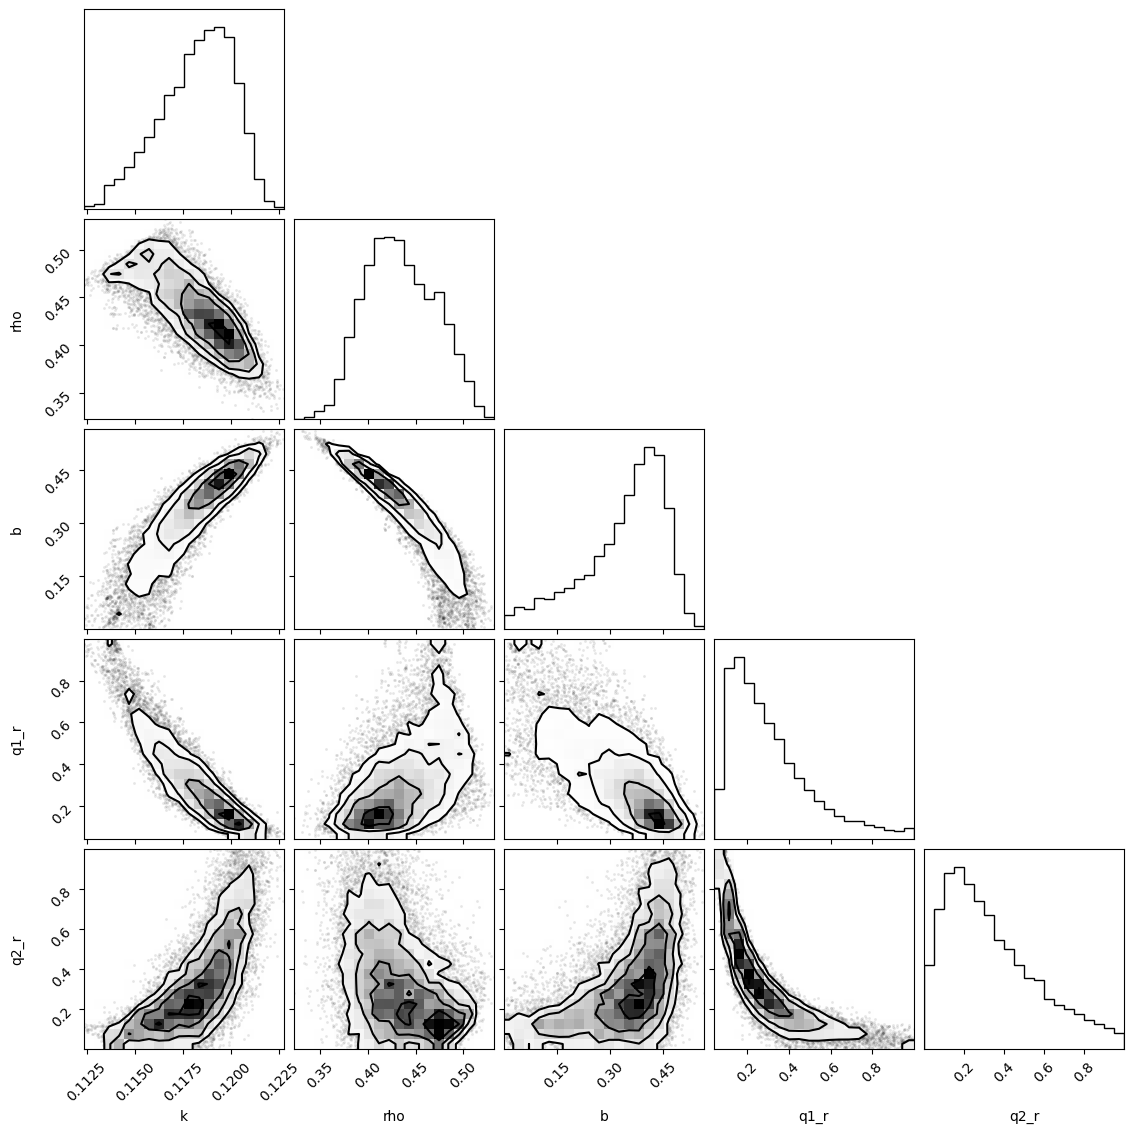

In [19]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols].values, labels=ccols);

### <span style="color:darkblue">Questions and exercises</span>

1. Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere) Give the answer in Jupiter radii.

- Answer.

The radius of Wasp-12 is $1.57\,\mathrm{R_\odot}$ [(Kokori et al. 2022)](https://iopscience.iop.org/article/10.3847/1538-4365/ac3a10). Looking at the corner plot we can see that the distribution of $k$ (and also $\rho$) are not normal (i.e. not Gaussian). However because the asymmetry is not extreme let us assume that the uncertainties can be obtained as the 1$\sigma$ deviationss from the median, although a more thorough approach would be ideal. The planetary radius will then be:

In [20]:
import numpy as np
from IPython.display import display, Markdown
rp_rstar = df.k #distribution
Solar_radius = 695700 #km
R_J = 69911 #km

Wasp_12_r = 1.57 # in solar raii

R_wasp12b_j_ = (rp_rstar*Wasp_12_r)*Solar_radius/R_J

R_wasp12b_j_err = np.quantile(R_wasp12b_j_,q=[0.16,0.5,0.84]) 

R_wasp12b_j_upper_err = np.abs(median(R_wasp12b_j_)-R_wasp12b_j_err[-1])
R_wasp12b_j_lower_err = np.abs(median(R_wasp12b_j_)-R_wasp12b_j_err[0])

R_wasp12b_j = median(R_wasp12b_j_)


string = "The radius of Wasp-12b with 1$\sigma$ uncertainties is: $R_P=$ {:2.2f} $^{{+{:.2f}}}_{{-{:.2f}}} \,\mathrm{{R_J}}$".format(R_wasp12b_j, R_wasp12b_j_upper_err, R_wasp12b_j_lower_err)
display(Markdown(string))

The radius of Wasp-12b with 1$\sigma$ uncertainties is: $R_P=$ 1.85 $^{+0.03}_{-0.03} \,\mathrm{R_J}$

For comparison [Hebb et al (2009)](https://iopscience.iop.org/article/10.1088/0004-637X/693/2/1920) got $R_P = 1.79^{+0.09}_{-0.09}\,\mathrm{{R_J}}$

2. Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.

- Answer.

Let us look at the distribution of $\rho$.

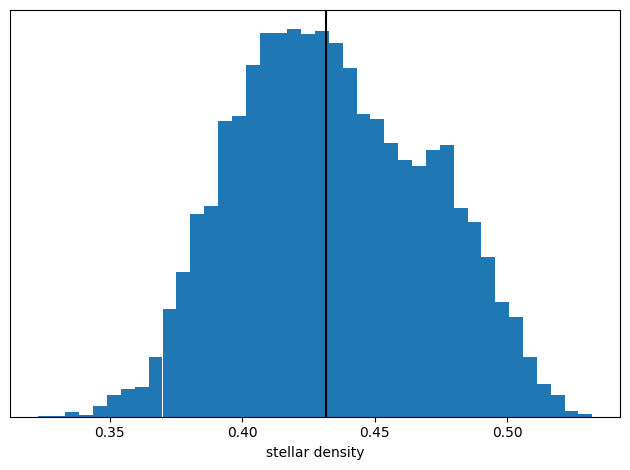

In [21]:
fig, ax = subplots()
ax.hist(df.rho, bins=40)
ax.axvline(median(df.rho), c='k')
setp(ax, xlabel='stellar density', yticks=[])
#ax.legend(frameon=False)
fig.tight_layout()

The distribution is slightly asymmetrical, nevertheless let us assume that the median is representative.

In [22]:
rho_wasp12b_j = median(df.rho)

rho_wasp12b_j_err = np.quantile(df.rho,q=[0.16,0.5,0.84]) 

rho_wasp12b_j_upper_err = np.abs(median(rho_wasp12b_j)-rho_wasp12b_j_err[-1])
rho_wasp12b_j_lower_err = np.abs(median(rho_wasp12b_j)-rho_wasp12b_j_err[0])


string = "The median stellar density of Wasp-12b (model) with 1$\sigma$ uncertainties is: $\\rho_{{\star}}$ = {:2.2f} $^{{+{:.2f}}}_{{-{:.2f}}} \,\mathrm{{g\,cm^{{-3}}}}$".format(rho_wasp12b_j, rho_wasp12b_j_upper_err, rho_wasp12b_j_lower_err)
display(Markdown(string))

The median stellar density of Wasp-12b (model) with 1$\sigma$ uncertainties is: $\rho_{\star}$ = 0.43 $^{+0.04}_{-0.03} \,\mathrm{g\,cm^{-3}}$

For comparison [Hebb et al (2009)](https://iopscience.iop.org/article/10.1088/0004-637X/693/2/1920) got $\rho_\star = 0.35^{+0.03}_{-0.03}\,\mathrm{{\rho_\odot}} \sim 0.49 \,\mathrm{g\,cm^{-3}}$. A very simple thoretical approximation to the problem can be given by 

$$
\rho = \frac{M_\star}{V_\star} = \frac{M_\star}{\frac{4}{3}\pi R_\star ^3}
$$


From the other notebook the mass of Wasp-12 is $M_\star  \sim 1.25\,\mathrm{M_\odot} $ ([Weinberg et al. 2017](https://iopscience.iop.org/article/10.3847/2041-8213/aa9113/meta)), and the radius is $1.57\,\mathrm{R_\odot}$ [(Kokori et al. 2022)](https://iopscience.iop.org/article/10.3847/1538-4365/ac3a10). Then the theoretical density would be: $\rho_\star = 0.45 \,\mathrm{g\,cm^{-3}}$.

We can see that the theoretical and the value derived from the model are within uncertainties of eachother. This is also case for the published value which is $\rho_\star \sim 0.49\,\mathrm{g\,cm^{-3}}$. In the next table the results are summarised, all units in cgs, in order from left to right: theoretical, model and published values for the stellar density.

| $\rho_{th}$ | $\rho_{mo}$ | $\rho_{pb}$ |
| --- | --- | --- |
| $0.45 $ | $0.43^{+0.03}_{-0.03}$ | $\sim 0.49$ |


3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?

- Answer.


It means that there are degeneracies between the parameters. That is, a number of different combinations of these parameters could yield an equally "good" fit. This is the case for the limb darkening coefficients which are correlated to the impact parameter ($b$) and planet to star ratio ($k$). Moreover the LDC have values between 0 and 1 and looking at the corner plot, in particular the correlation plot between $q_1$ and $q_2$, it can be seen that these parameters can both take values between 0.2 and 0.8. This means that there is a srong degeneracy and that it is difficult to obtain physical information from these values.

This is an issue because if there are other parameters derived from those which are correlated there will be a large propagation of uncertainties. Moreover the mcmc can get stuck on local solutions and not converge to the best fit because of these correlations. One way to solve this is via reparametrization, as in the case of $\sqrt{e}\cos \omega$ and $\sqrt{e}\sin \omega$ in the radial velocity case. This improves performance and reduces the chances of getting stuck in local solutions. There are also a number of other solutions like: fixing the values of the limb darkening coefficients or letting them evolve freely or within some bounds.

---
<center>&copy;2024 Hannu Parviainen</center>